This notebook is used to evaluate the hyperparameter tuned random forest models; outputs auc_roc plot, probability histograms

In [9]:
import pandas as pd
import seaborn as sns

In [10]:
#!pip install seaborn

In [11]:
#load data
#load df
segment = 'test'
#X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

In [12]:
#jied
def RF_model_builder2(n_estimators = 100,
                    criterion = 'gini',
                    max_depth = None,
                    min_samples_split = 2,
                    min_samples_leaf = 1,
                    max_features = 'sqrt',
                    max_leaf_nodes = None,
                    min_weight_fraction_leaf = 0.0,
                    random_state = 42
                     ):
    
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion,
                                   max_depth = max_depth, 
                                   min_samples_split = min_samples_split, 
                                   min_samples_leaf = min_samples_leaf, 
                                   max_features = max_features, 
                                   max_leaf_nodes = max_leaf_nodes,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf,
                                   random_state = 42)
    return model

In [13]:
#X.columns

In [14]:
#define function that onehot encodes, models Random Forest, and gives out AUC
def RF_ohe_model_auc(cleaned_df, rf_model,segment=segment):
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import mean_absolute_error
    import pandas as pd
    import numpy as np
    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
    #from catboost.utils import get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve
    from sklearn.metrics import RocCurveDisplay
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    #load df
    X_full = cleaned_df.copy()

    #remove rows with missing target: D3_within12months, loan_account_no
    X_full.dropna(axis=0, subset=['D3_within12months'], inplace=True)
    y = X_full.D3_within12months
    X_full.drop(['D3_within12months', 'loan_account_no'], axis=1, inplace=True)

    from sklearn.model_selection import train_test_split
    X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, 
                                                                   train_size=0.8, test_size=0.2,
                                                                   random_state=11, stratify = y)

    #select categorical columns
    categorical_cols = [cname for cname in X_train_full.columns if
                       X_train_full[cname].dtype == "object"]

    numerical_cols = [cname for cname in X_train_full.columns if
                     X_train_full[cname].dtype in ['int64', 'float64']]

    #keep selected columns only
    my_cols = categorical_cols + numerical_cols
    X_train = X_train_full[my_cols].copy()
    X_test = X_test_full[my_cols].copy()


    #preprocess numerical data
    numerical_transformer = SimpleImputer(strategy='constant')

    #preprocessing categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))
    ])

    #Bundle preprocessing for num and categ data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num',numerical_transformer,numerical_cols),
            ('cat',categorical_transformer,categorical_cols)
        ]
    )

    model = rf_model

    #Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor',preprocessor),
                         ('model', model)
                         ])

    #preprocessing of training data, fit model
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba)
    
    #compute optimal threshold based on roc_auc curve only
    opt = true_positive_rate - false_positive_rate
    tp_fp_diff = pd.DataFrame({'thresholds': threshold, 'tpr_fpr': opt})

    max_index = tp_fp_diff.tpr_fpr.argmax()
    THRESHOLD = tp_fp_diff.iloc[max_index][0]
    
    y_pred = np.where(y_pred_proba > THRESHOLD, 1, 0)

    plt.subplots(1, figsize = (5,5))
    luh = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC_AUC Curve: {luh:.2f}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0,1], ls = "--")
    plt.plot([0,0],[1,0], c= ".7"), plt.plot([1,1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(classification_report(y_test, y_pred, target_names = ['Good Customer','Bad Customer']))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cnf_matrix)
    print(tn, fp, fn, tp)
    
    sns.distplot(y_pred_proba)
    plt.show()
    
    feat_importances = clf.named_steps['model'].feature_importances_
    feature_names = clf.named_steps['preprocessor'].get_feature_names_out()

    feat_imp_df = pd.DataFrame({
        'variable':feature_names,
        'feature_importances':feat_importances
    })
    
    feat_imp_df.to_csv(f'./Feature_Importance/featimportance_RF_{segment}.csv', index=False)

    feat_imp_df = feat_imp_df.sort_values(by='feature_importances', ascending=False)
    print(feat_imp_df[:20])

In [15]:
#ntc base
# rf_NTC_v1 = RF_model_builder2(min_samples_split = 0.2,
#                         max_depth = 5)

# RF_ohe_model_auc(load_clean_data2('NTC'), rf_NTC_v1, 'NTC')

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


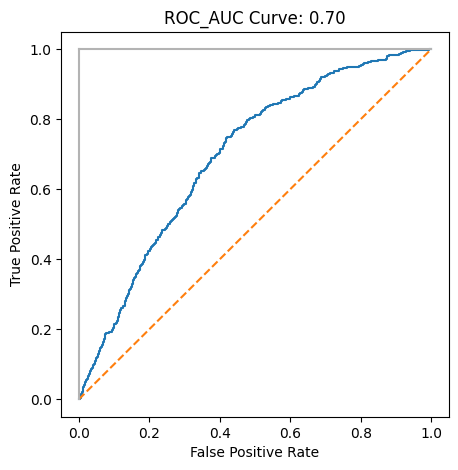

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.96      0.56      0.71      3492
 Bad Customer       0.14      0.77      0.24       338

     accuracy                           0.58      3830
    macro avg       0.55      0.66      0.47      3830
 weighted avg       0.89      0.58      0.67      3830

[[1950 1542]
 [  79  259]]
1950 1542 79 259


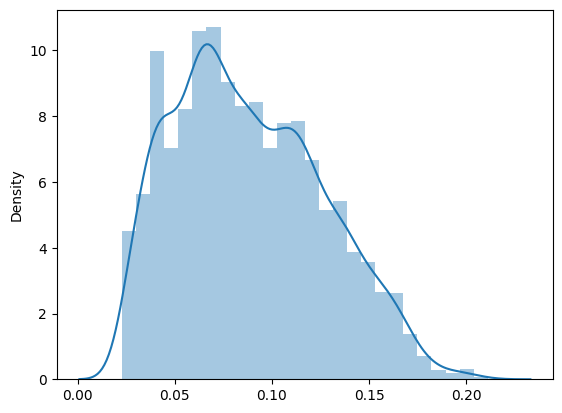

                                             variable  feature_importances
2                            num__down_payment_amount             0.194817
10                                      num__dp_ratio             0.126208
5                         num__number_of_installments             0.102396
26                            cat__branch_grp_GROUP_D             0.072269
39                         cat__res_state_grp_GROUP_C             0.061762
6                                num__loan_asset_cost             0.048031
4                                  num__interest_rate             0.047719
40                cat__res_resident_status_grp_RENTED             0.047281
1                                            num__age             0.041904
37                          cat__res_city_grp_GROUP_D             0.041077
9                                 num__monthly_income             0.034197
7                   num__res_years_at_current_address             0.034129
0                      nu

In [16]:
#ntc tuned randomgridsearchcv
rf_NTC_vf = RF_model_builder2(n_estimators = 58,
                    criterion = 'gini',
                    max_depth = 9,
                    min_samples_split = 2,
                    min_samples_leaf = 45,
                    max_features = 'sqrt',
                    max_leaf_nodes = 24,
                    min_weight_fraction_leaf = 0.007818203370596966,
                    random_state = 42)
segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_NTC_vf)

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


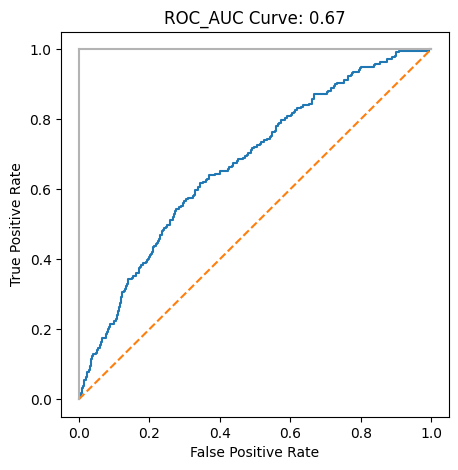

               precision    recall  f1-score   support

Good Customer       0.94      0.66      0.77      2177
 Bad Customer       0.15      0.61      0.24       219

     accuracy                           0.65      2396
    macro avg       0.55      0.63      0.51      2396
 weighted avg       0.87      0.65      0.73      2396

[[1428  749]
 [  85  134]]
1428 749 85 134


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


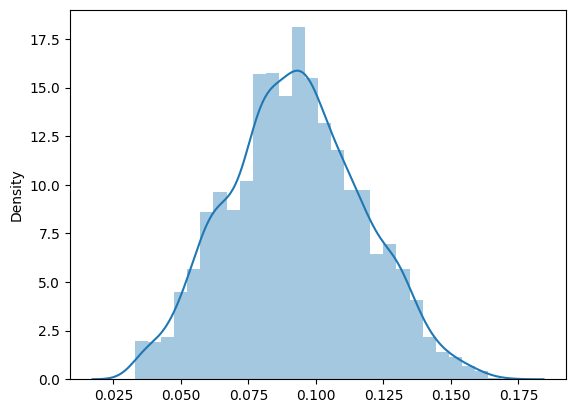

                                             variable  feature_importances
1                                            num__age             0.148210
5                         num__number_of_installments             0.126977
10                                      num__dp_ratio             0.125038
2                            num__down_payment_amount             0.120362
26                            cat__branch_grp_GROUP_D             0.075719
39                         cat__res_state_grp_GROUP_C             0.048227
6                                num__loan_asset_cost             0.047553
40                cat__res_resident_status_grp_RENTED             0.034811
0                      num__res_years_at_current_city             0.031128
37                          cat__res_city_grp_GROUP_D             0.030435
9                                 num__monthly_income             0.030413
7                   num__res_years_at_current_address             0.028615
3                        

In [17]:
#low_CIBIL tuned randomgridsearchcv
rf_low_CIBIL_vf = RF_model_builder2(n_estimators = 493,
                    criterion = 'entropy',
                    max_depth = 5,
                    min_samples_split = 7,
                    min_samples_leaf = 158,
                    max_features = 'log2',
                    max_leaf_nodes = 353,
                    min_weight_fraction_leaf = 0.00038938292050716417,
                    random_state = 42)
segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_low_CIBIL_vf, segment)

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


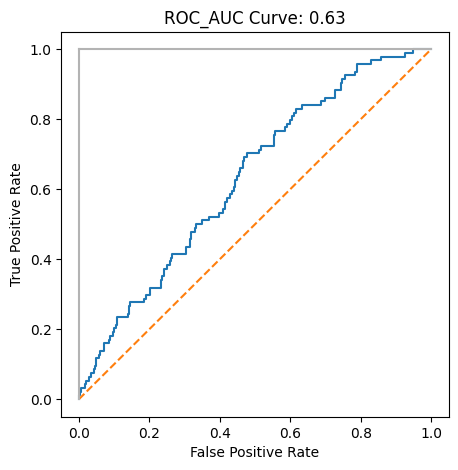

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.96      0.52      0.68      1475
 Bad Customer       0.08      0.69      0.15        94

     accuracy                           0.53      1569
    macro avg       0.52      0.61      0.41      1569
 weighted avg       0.91      0.53      0.65      1569

[[771 704]
 [ 29  65]]
771 704 29 65


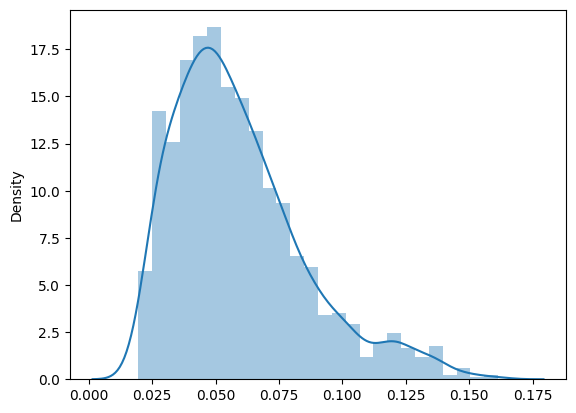

                                             variable  feature_importances
2                            num__down_payment_amount             0.137402
10                                      num__dp_ratio             0.117829
1                                            num__age             0.097743
6                                num__loan_asset_cost             0.080125
5                         num__number_of_installments             0.061001
0                      num__res_years_at_current_city             0.054085
39                         cat__res_state_grp_GROUP_C             0.052836
40                cat__res_resident_status_grp_RENTED             0.050752
7                   num__res_years_at_current_address             0.048581
3                                   num__total_income             0.044772
4                                  num__interest_rate             0.044593
9                                 num__monthly_income             0.042961
26                       

In [18]:
#mid_CIBIL tuned randomgridsearchcv
rf_mid_CIBIL_vf = RF_model_builder2(n_estimators = 58,
                    criterion = 'gini',
                    max_depth = 9,
                    min_samples_split = 2,
                    min_samples_leaf = 45,
                    max_features = 'sqrt',
                    max_leaf_nodes = 24,
                    min_weight_fraction_leaf = 0.007818203370596966,
                    random_state = 42)

segment = 'mid_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_mid_CIBIL_vf, segment)

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


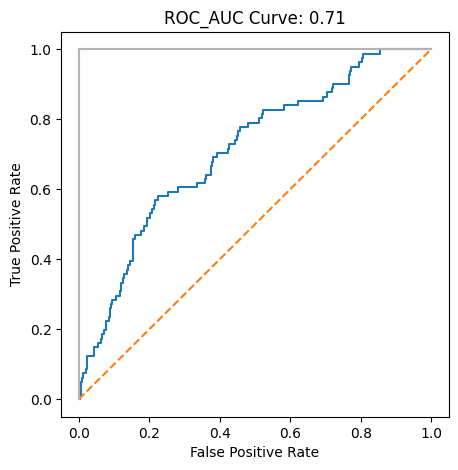

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19500\3752324747.py:100: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


               precision    recall  f1-score   support

Good Customer       0.98      0.78      0.87      2565
 Bad Customer       0.07      0.57      0.13        81

     accuracy                           0.77      2646
    macro avg       0.53      0.67      0.50      2646
 weighted avg       0.95      0.77      0.84      2646

[[1990  575]
 [  35   46]]
1990 575 35 46


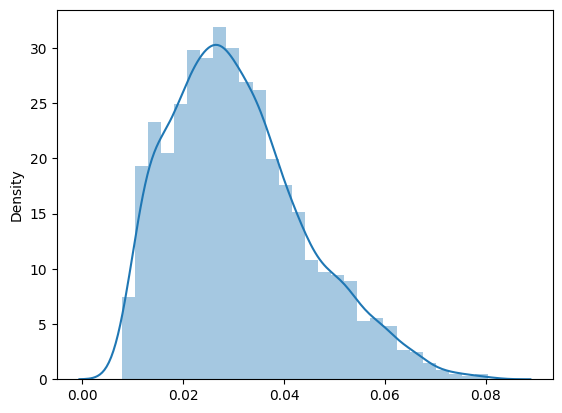

                               variable  feature_importances
2              num__down_payment_amount             0.164308
10                        num__dp_ratio             0.146219
40  cat__res_resident_status_grp_RENTED             0.086507
1                              num__age             0.077752
5           num__number_of_installments             0.068564
4                    num__interest_rate             0.052102
6                  num__loan_asset_cost             0.050750
39           cat__res_state_grp_GROUP_C             0.049133
26              cat__branch_grp_GROUP_D             0.040489
7     num__res_years_at_current_address             0.034828
0        num__res_years_at_current_city             0.032658
9                   num__monthly_income             0.028227
3                     num__total_income             0.027152
19        cat__manufacturer_grp_GROUP_B             0.018650
34        cat__asset_model_grp_SPLENDOR             0.018025
37            cat__res_c

In [19]:
#high_CIBIL tuned randomgridsearchcv
rf_high_CIBIL_vf = RF_model_builder2(n_estimators = 493,
                    criterion = 'entropy',
                    max_depth = 5,
                    min_samples_split = 7,
                    min_samples_leaf = 158,
                    max_features = 'log2',
                    max_leaf_nodes = 353,
                    min_weight_fraction_leaf = 0.00038938292050716417,
                    random_state = 42)
segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
RF_ohe_model_auc(X, rf_high_CIBIL_vf, segment)